In [28]:
!pip install torchsummary
!pip install matplotlib --upgrade
!pip install scipy
!pip install foolbox

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import CIFAR10, FashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torch import nn
from torchvision import transforms
from tqdm import tqdm
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Loading datasets

In [30]:
def display_imgs(dataset, num_images_per_class, title='', supylabel='class images'):
  fig, axs = plt.subplots(nrows=num_images_per_class, ncols=num_classes, figsize=[1.5*num_classes, 1.5*num_images_per_class])
  fig.supylabel(supylabel)
  fig.suptitle(title)
  for class_idx in range(num_classes):
    axs[num_images_per_class-1][class_idx].set_xlabel(idx_to_class[class_idx])
    count = num_images_per_class
    for image, label in dataset:
      if label == class_idx:
        count -= 1
        axs[count][class_idx].imshow(transforms.ToPILImage()(image))
      if count == 0:
        break
  fig.show()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting datasets/FMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to datasets/FMNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting datasets/FMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to datasets/FMNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting datasets/FMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to datasets/FMNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting datasets/FMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to datasets/FMNIST\FashionMNIST\raw



C:\Users\incre\AppData\Local\Temp\ipykernel_8096\2127074941.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


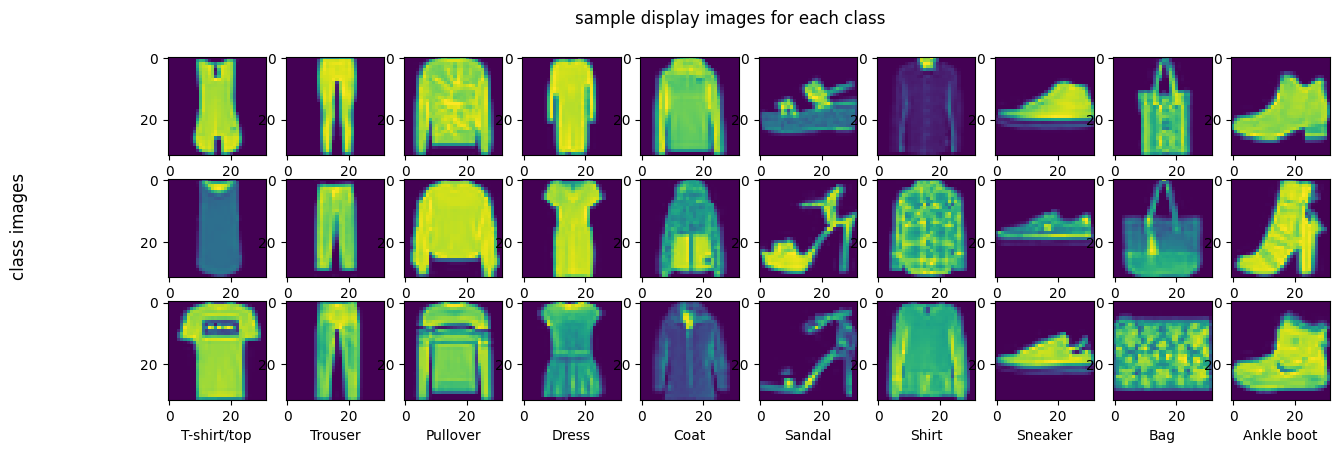

In [31]:
C, H, W = [1, 32, 32]
num_classes = 10
tfms = transforms.Compose([
    transforms.Grayscale(C),
    transforms.ToTensor(),
    transforms.Resize([H, W]),
])
train_dataset = torchvision.datasets.FashionMNIST(root='datasets/FMNIST', train=True, transform=tfms, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='datasets/FMNIST', train=False, transform=tfms, download=True)
idx_to_class = {value:key for key, value in train_dataset.class_to_idx.items()}
class_to_idx = {key:value for key, value in train_dataset.class_to_idx.items()}
display_imgs(train_dataset, 3, title='sample display images for each class')

In [ ]:
# C, H, W = [3, 96, 96]
# tfms=transforms.Compose(
#     [
#         transforms.Resize([96, 96]),
#         transforms.ToTensor(),
#     ]
# )
# train_dataset = OxfordIIITPet(root='datasets/oxford', split='trainval', target_types='category', transform=tfms, download=True)
# test_dataset  = OxfordIIITPet(root='datasets/oxford', split='test'    , target_types='category', transform=tfms, download=True)
# idx_to_class = {value:key for key, value in train_dataset.class_to_idx.items()}
# class_to_idx = {key:value for key, value in train_dataset.class_to_idx.items()}
# display_imgs(OxfordIIITPet(root='datasets/oxford', split='trainval', target_types='category', transform=tfms, download=True), 3, title='sample display images for each class')

In [32]:
def bn_track(model):
  for m in model.modules():
      for child in m.children():
          if type(child) == nn.BatchNorm2d:
              print(child.track_running_stats)
              print(child.running_mean)
              print(child.running_var)

def bn_define(model):
  for m in model.modules():
    for child in m.children():
      if type(child) == nn.BatchNorm2d:
        child.track_running_stats = True
        child.running_mean = torch.zeros_like(child.running_mean)
        child.running_var = torch.ones_like(child.running_var)

def bn_compute(model, loader):
  bn_define(model)
  model.train()
  model = model.to(device)
  for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.to(device)
    preds = model(images).argmax(dim=1)

# victim V

## victim class

In [33]:
class Victim(nn.Module):
  def __init__(self, H, W, num_classes):
    super().__init__()

    self.features = nn.Sequential(
        nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ),


        nn.AdaptiveAvgPool2d((H//32, W//32)),
        nn.Flatten(),
    )

    self.classifier = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(True),
        nn.Linear(256, 128),
        nn.ReLU(True),
        nn.Linear(128, num_classes),
    )
    self._initialize_weights()
  
  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x
  
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

victim = Victim(H, W, num_classes).to(device)
bn_define(victim)
summary(victim, (C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
         AvgPool2d-4            [-1, 8, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,168
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
         AvgPool2d-8             [-1, 16, 8, 8]               0
            Conv2d-9             [-1, 32, 8, 8]           4,640
      BatchNorm2d-10             [-1, 32, 8, 8]              64
             ReLU-11             [-1, 32, 8, 8]               0
        AvgPool2d-12             [-1, 32, 4, 4]               0
           Conv2d-13             [-1, 64, 4, 4]          18,496
      BatchNorm2d-14             [-1, 6

## helper functions for training

In [34]:
def get_loss(model, loader, criterion):
  model.eval()
  losses = []
  sizes = []
  with torch.no_grad():
    for images, labels in tqdm(loader):
      images, labels = images.to(device), labels.to(device)
      scores = model(images)
      loss = criterion(scores, labels)
      losses.append(loss.item())
      sizes.append(images.shape[0])
  model.train()
  losses, sizes = np.array(losses), np.array(sizes)
  return sum(losses * sizes) / sum(sizes)

def get_accuracy(model, loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in tqdm(loader):
      images, labels = images.to(device), labels.to(device)
      scores = model(images)
      preds = scores.argmax(dim=1)
      correct += sum(preds == labels)
      total += sum(labels == labels)
  model.train()
  return correct / total

## training victim

In [35]:
victim_kwargs = {
    'H': H,
    'W': W,
    'num_classes': num_classes,
}
victim = Victim(**victim_kwargs).to(device)
summary(victim, (C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
         AvgPool2d-4            [-1, 8, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,168
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
         AvgPool2d-8             [-1, 16, 8, 8]               0
            Conv2d-9             [-1, 32, 8, 8]           4,640
      BatchNorm2d-10             [-1, 32, 8, 8]              64
             ReLU-11             [-1, 32, 8, 8]               0
        AvgPool2d-12             [-1, 32, 4, 4]               0
           Conv2d-13             [-1, 64, 4, 4]          18,496
      BatchNorm2d-14             [-1, 6

In [36]:
num_epochs = 10
learning_rate = 3e-4
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(victim.classifier.parameters(), lr=learning_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [38]:
losses = []

In [ ]:
# # warmup
# for images, labels in tqdm(train_loader):
#   images, labels = images.to(device), labels.to(device)
#   optimizer.zero_grad()
#   scores = victim(images)
#   loss = criterion(scores, labels)
#   loss.backward()
#   optimizer.step()

training starts!
start of epoch 1-


100%|██████████| 313/313 [00:02<00:00, 109.32it/s]


end of epoch 1, train_loss:0.563, test_loss:0.580, train_accuracy:78.653, test_accuracy:78.260


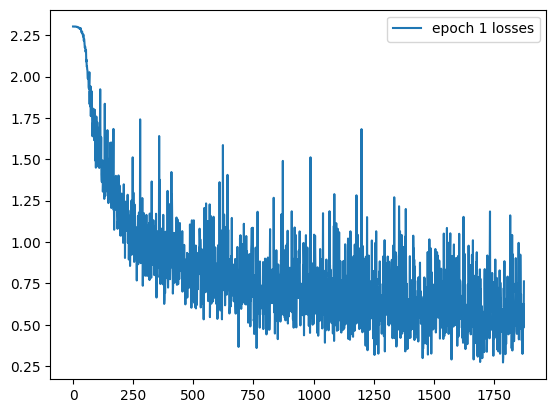

start of epoch 2-


100%|██████████| 313/313 [00:02<00:00, 112.27it/s]


end of epoch 2, train_loss:0.430, test_loss:0.455, train_accuracy:83.387, test_accuracy:82.730


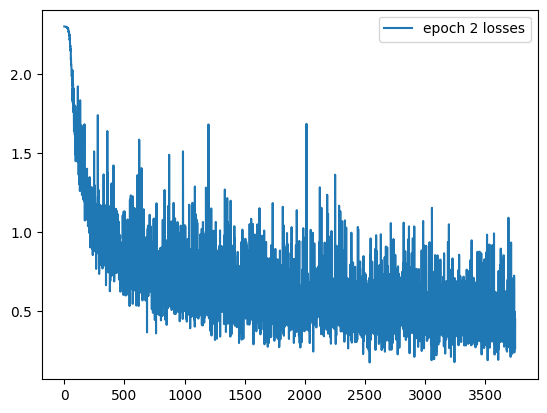

start of epoch 3-


100%|██████████| 313/313 [00:02<00:00, 109.92it/s]

end of epoch 3, train_loss:0.395, test_loss:0.422, train_accuracy:85.853, test_accuracy:84.920


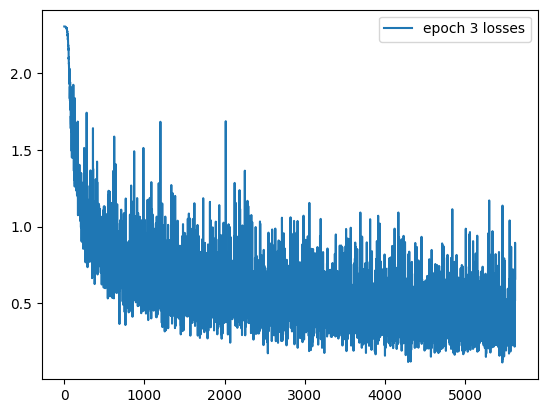

start of epoch 4-


100%|██████████| 313/313 [00:02<00:00, 113.13it/s]


end of epoch 4, train_loss:0.381, test_loss:0.421, train_accuracy:86.108, test_accuracy:84.720


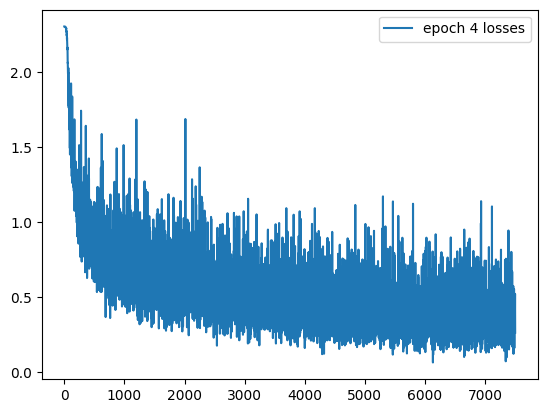

start of epoch 5-


100%|██████████| 313/313 [00:02<00:00, 111.75it/s]


end of epoch 5, train_loss:0.349, test_loss:0.390, train_accuracy:87.428, test_accuracy:86.160


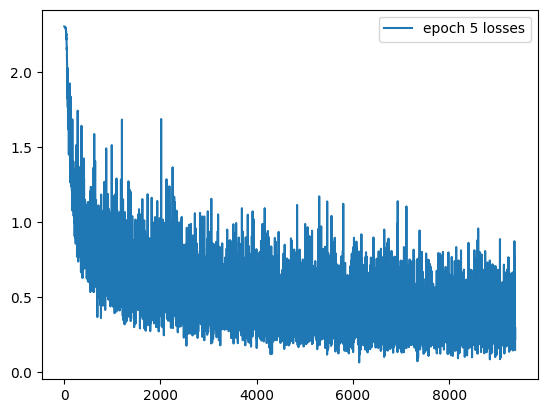

start of epoch 6-


100%|██████████| 313/313 [00:02<00:00, 106.12it/s]


end of epoch 6, train_loss:0.289, test_loss:0.329, train_accuracy:89.543, test_accuracy:88.520


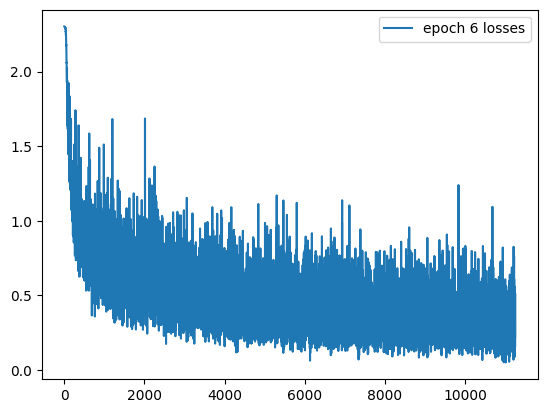

start of epoch 7-


100%|██████████| 313/313 [00:02<00:00, 112.47it/s]


end of epoch 7, train_loss:0.291, test_loss:0.335, train_accuracy:89.572, test_accuracy:88.160


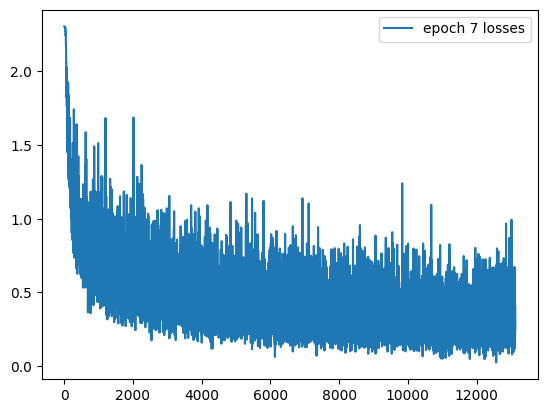

start of epoch 8-


100%|██████████| 313/313 [00:02<00:00, 113.46it/s]


end of epoch 8, train_loss:0.404, test_loss:0.457, train_accuracy:85.588, test_accuracy:83.870


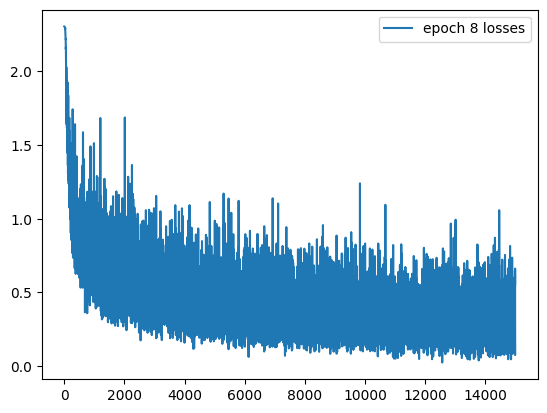

start of epoch 9-


100%|██████████| 313/313 [00:02<00:00, 113.49it/s]


end of epoch 9, train_loss:0.280, test_loss:0.338, train_accuracy:89.768, test_accuracy:88.090


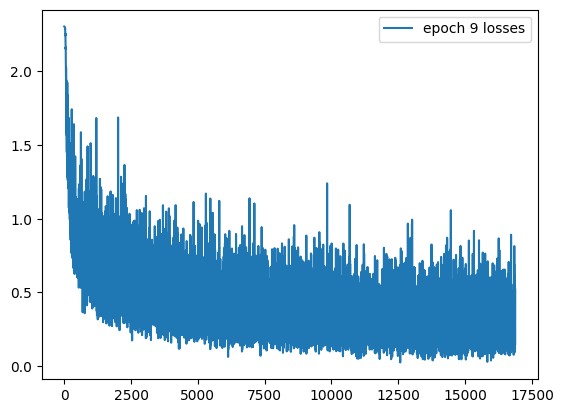

start of epoch 10-


100%|██████████| 313/313 [00:02<00:00, 112.90it/s]


end of epoch 10, train_loss:0.278, test_loss:0.338, train_accuracy:89.697, test_accuracy:87.860


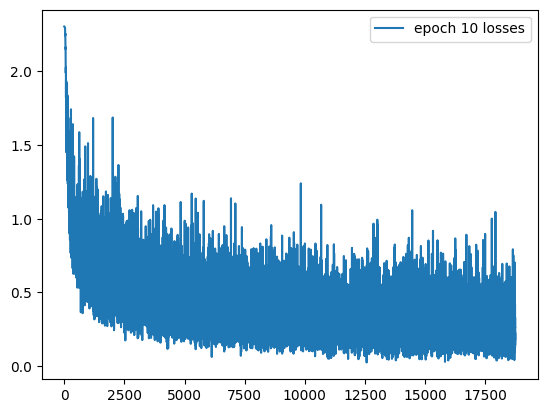

In [39]:
optimizer = torch.optim.Adam(victim.parameters(), lr=learning_rate)

# train_losses.append(get_loss(victim, train_loader, criterion))
# test_losses .append(get_loss(victim, test_loader , criterion))
# train_accuracies.append(get_accuracy(victim, train_loader))
# test_accuracies .append(get_accuracy(victim, test_loader ))
print(f'training starts!')
for epoch in range(num_epochs):
  print(f'start of epoch {epoch+1}-')
  for images, labels in tqdm(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    scores = victim(images)
    loss = criterion(scores, labels)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
  train_losses.append(get_loss(victim, train_loader, criterion))
  test_losses .append(get_loss(victim, test_loader , criterion))
  train_accuracies.append(get_accuracy(victim, train_loader))
  test_accuracies .append(get_accuracy(victim, test_loader ))
  print(f'end of epoch {epoch+1}, train_loss:{train_losses[-1]:.3f}, test_loss:{test_losses[-1]:.3f}, train_accuracy:{100*train_accuracies[-1]:.3f}, test_accuracy:{100*test_accuracies[-1]:.3f}')
  plt.plot(losses, label=f'epoch {epoch+1} losses')
  plt.legend()
  plt.show()

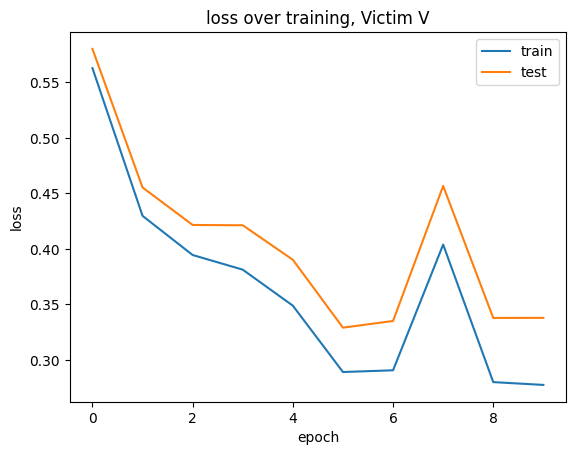

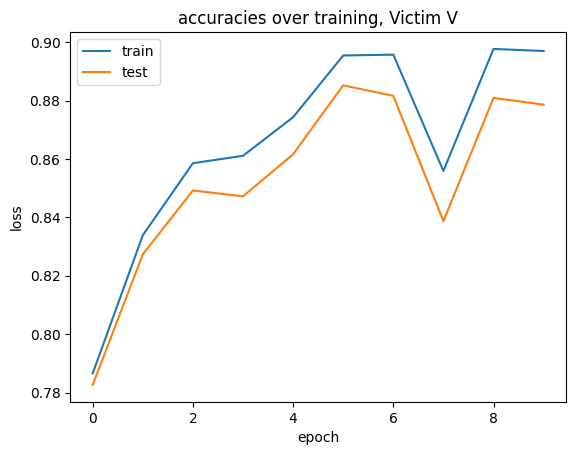

In [40]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('loss over training, Victim V')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot([item.item() for item in train_accuracies], label='train')
plt.plot([item.item() for item in test_accuracies], label='test')
plt.title('accuracies over training, Victim V')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [41]:
PATH_VICTIM = "saved/victim2_fmnist.pt"

# save
torch.save(victim.to('cpu').state_dict(), PATH_VICTIM)

# load
victim_saved = Victim(**victim_kwargs)
victim_saved.load_state_dict(torch.load(PATH_VICTIM))
victim_saved = victim_saved.to(device)
bn_compute(victim_saved, DataLoader(train_dataset, batch_size, shuffle=True))

100%|██████████| 1875/1875 [00:14<00:00, 127.36it/s]


# autoencoder

In [42]:
# reference code snippet modified here - https://gist.github.com/anderzzz/1adfa12a409e6367f41fa60c8c2d5bb7
class DecoderVGG(nn.Module):
    '''Decoder of code based on the architecture of VGG-16 with batch normalization.
    Args:
        encoder: The encoder instance of `EncoderVGG` that is to be inverted into a decoder
    '''
    def __init__(self):
        super(DecoderVGG, self).__init__()

        # define the encoder portion which is the same as the victim model...
        encoder = Victim(H, W, num_classes).features
        self.encoder = encoder


        # define the inverse of the encoder
        self.decoder_stack = self._invert_(encoder[0])
        self.decoder = nn.Sequential(*self.decoder_stack)


    def decode(self, fl, fs):
      embeddings = torch.cat(tensors=(fl, fs), dim=1)
      x_hat = self.decoder(embeddings)
      return x_hat
    

    def forward(self, x, label_embeddings):
      semantic_embeddings = self.encoder(x)
      # not sure whether to use concatenation or addition here. some details absent or not clearly explained in the paper are the cause.
      embeddings = torch.cat(tensors=(label_embeddings, semantic_embeddings), dim=1)
      # embeddings = label_embeddings + semantic_embeddings 
      x_hat = self.decoder(embeddings)
      return x_hat


    def _invert_(self, encoder):
        '''Invert the encoder in order to create the decoder as a (more or less) mirror image of the encoder
        The decoder is comprised of two principal types: the 2D transpose convolution and the 2D unpooling. The 2D transpose
        convolution is followed by batch normalization and activation. Therefore as the module list of the encoder
        is iterated over in reverse, a convolution in encoder is turned into transposed convolution plus normalization
        and activation, and a maxpooling in encoder is turned into unpooling.
        Args:
            encoder (ModuleList): the encoder
        Returns:
            decoder (ModuleList): the decoder obtained by "inversion" of encoder
        '''
        # modules_transpose = [nn.Linear(128, 64), nn.BatchNorm2d(64), nn.ReLU(), nn.Unflatten(1, (64, 1, 1)), nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=4, padding=0)]
        modules_transpose = [nn.Linear(128, 64), nn.ReLU(), nn.Unflatten(1, (64, 1, 1)), nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=4, padding=0)]
        unpool_channel_list = [8, 16, 32]
        for module in reversed(encoder):

            if isinstance(module, nn.Conv2d):
                kwargs = {'in_channels' : module.out_channels, 'out_channels' : module.in_channels,
                          'kernel_size' : module.kernel_size, 'stride' : module.stride,
                          'padding' : module.padding}
                module_transpose = nn.ConvTranspose2d(**kwargs)
                module_norm = nn.BatchNorm2d(module.in_channels)
                module_act = nn.ReLU(inplace=True)
                modules_transpose += [module_transpose, module_norm, module_act]

            elif isinstance(module, nn.AvgPool2d):
                channels = unpool_channel_list.pop()
                kwargs = {'in_channels' : channels, 'out_channels' : channels,
                          'kernel_size' : module.kernel_size, 'stride' : module.stride,
                          'padding' : module.padding}
                module_transpose = nn.ConvTranspose2d(**kwargs)
                # module_transpose.weight = nn.Parameter(torch.ones_like(module_transpose.weight))
                # module_transpose.bias = nn.Parameter(torch.zeros_like(module_transpose.bias))
                # module_transpose.weight.requires_grad_(False)
                # module_transpose.bias.requires_grad_(False)
                modules_transpose += [module_transpose]

        # Discard the final normalization and activation, so final module is convolution with bias
        modules_transpose = modules_transpose[:-2]

        return nn.ModuleList(modules_transpose)

drr_kwargs = {
    
}
DRR = DecoderVGG(**drr_kwargs).to(device)
bn_define(DRR)
DRR(torch.cuda.FloatTensor(2, C, H, W), torch.cuda.FloatTensor(2, 64)).shape

torch.Size([2, 1, 32, 32])

In [43]:
# print(DRR.encode(train_dataset[0][0].unsqueeze(dim=0).to(device)))
# print(DRR.encoder(train_dataset[0][0].unsqueeze(dim=0).to(device)))

In [44]:
summary(DRR.decoder, (128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           8,256
              ReLU-2                   [-1, 64]               0
         Unflatten-3             [-1, 64, 1, 1]               0
   ConvTranspose2d-4             [-1, 64, 4, 4]          65,600
   ConvTranspose2d-5             [-1, 32, 4, 4]          18,464
       BatchNorm2d-6             [-1, 32, 4, 4]              64
              ReLU-7             [-1, 32, 4, 4]               0
   ConvTranspose2d-8             [-1, 32, 8, 8]           4,128
   ConvTranspose2d-9             [-1, 16, 8, 8]           4,624
      BatchNorm2d-10             [-1, 16, 8, 8]              32
             ReLU-11             [-1, 16, 8, 8]               0
  ConvTranspose2d-12           [-1, 16, 16, 16]           1,040
  ConvTranspose2d-13            [-1, 8, 16, 16]           1,160
      BatchNorm2d-14            [-1, 8,

# training methodology

In [53]:
DRR = DecoderVGG(**drr_kwargs).to(device)
bn_define(DRR)
DRR = DRR.to(device)
DRR.train()
victim = victim.to(device)
victim.eval()
print()

In [54]:
# approach - specific hyperparameters
E = 8    # the number of counterexamples per xi
d = 0.2  # the threshold for farthest allowable distance for benign vs counterexamples
T = 2    # empirically a good value of temperature scaling generally

# other hyperparams
learning_rate = 0.001
batch_size = 32
train_loader, test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
optimizer = torch.optim.Adam(DRR.parameters(), lr=learning_rate)
softmax = nn.Softmax(dim=1)

In [55]:
DRR_AUTO_SAVE_PATH = 'saved/drr2_auto_fmnist.pt'
DRR_VICTIM_SAVE_PATH = 'saved/drr2_victim_fmnist.pt'

# # save
torch.save(DecoderVGG().state_dict(), DRR_AUTO_SAVE_PATH)
torch.save(victim.state_dict(), DRR_VICTIM_SAVE_PATH)

# # load
# DRR_mnist = DecoderVGG(**drr_kwargs)
# DRR_mnist.load_state_dict(torch.load(DRR_AUTO_SAVE_PATH))
# victim_mnist = Victim(**victim_kwargs)
# victim_mnist.load_state_dict(torch.load(DRR_VICTIM_SAVE_PATH))
# victim_mnist = victim_mnist.to(device)
# bn_compute(victim_mnist, DataLoader(train_dataset, 16, shuffle=True))

In [56]:
losses_drr = [[],[],[],[],[]]
run_id = 1

In [57]:
losses = []

In [ ]:
# DRR_AUTO_SAVE_PATH = ...
# DRR_VICTIM_SAVE_PATH = ...

# # load
# DRR = DecoderVGG(**drr_kwargs)
# DRR.load_state_dict(torch.load(DRR_AUTO_SAVE_PATH))
# victim = Victim(**victim_kwargs)
# victim.load_state_dict(torch.load(DRR_VICTIM_SAVE_PATH))
# victim = victim.to(device)
# bn_compute(victim, DataLoader(train_dataset, 16, shuffle=True))

In [58]:
victim = victim.to(device)
victim.train()
bn_compute(victim, DataLoader(train_dataset, 64, shuffle=True))
victim.eval()

100%|██████████| 938/938 [00:27<00:00, 33.72it/s]


Victim(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU()
    )
    (1): AdaptiveAvgPoo

  0%|          | 0/1875 [00:00<?, ?it/s]

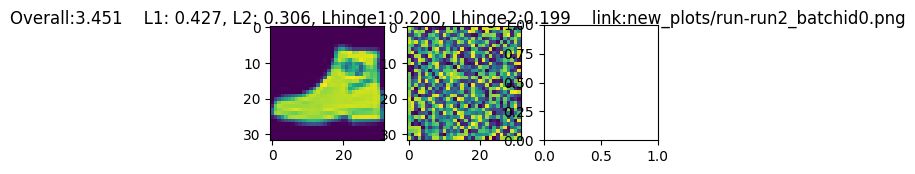

  1%|          | 20/1875 [01:00<1:31:33,  2.96s/it]

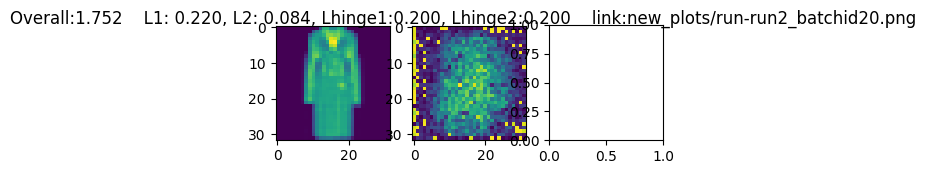

  2%|▏         | 40/1875 [02:00<1:31:06,  2.98s/it]

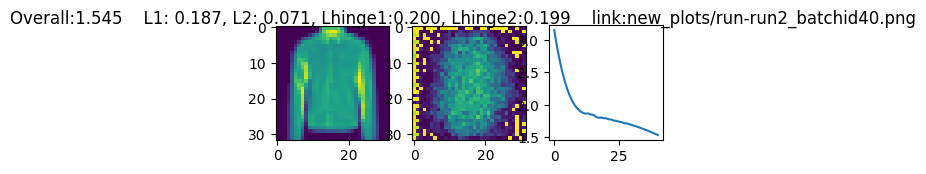

  3%|▎         | 60/1875 [03:01<1:30:37,  3.00s/it]

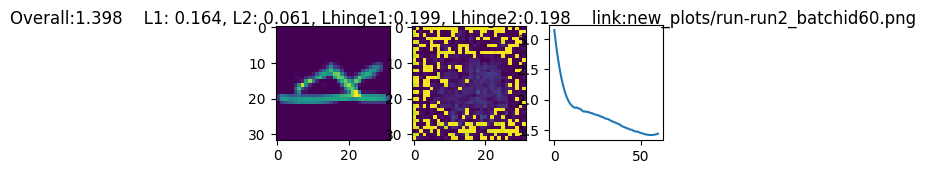

  4%|▍         | 80/1875 [04:01<1:28:14,  2.95s/it]

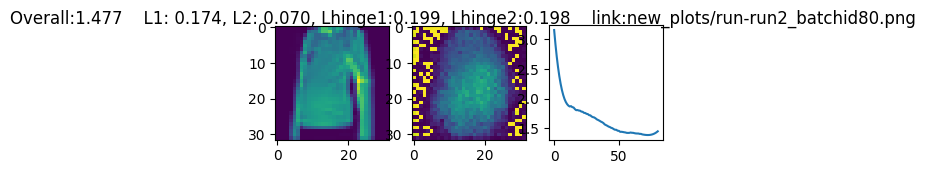

  5%|▌         | 100/1875 [05:01<1:28:15,  2.98s/it]

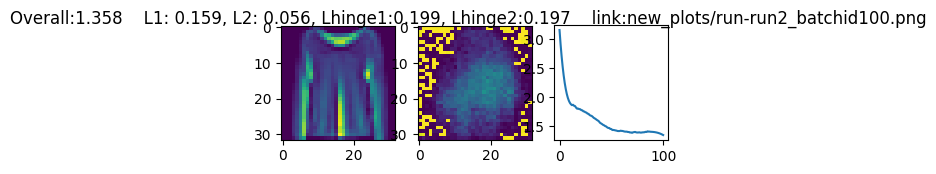

  6%|▋         | 120/1875 [06:01<1:27:31,  2.99s/it]

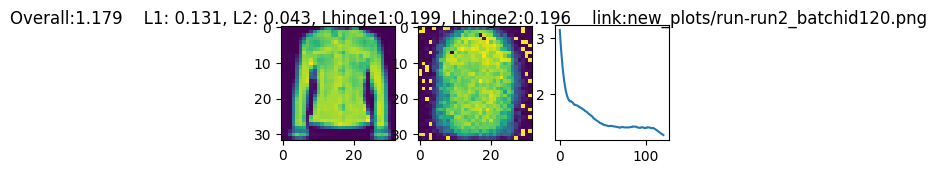

  7%|▋         | 140/1875 [07:02<1:27:04,  3.01s/it]

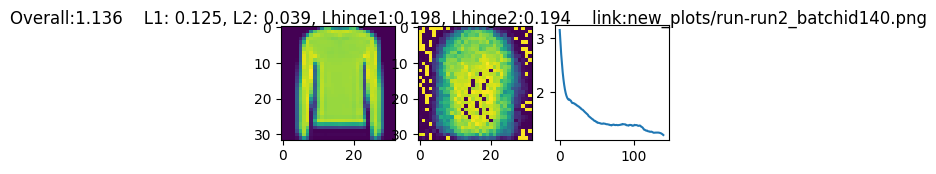

  9%|▊         | 160/1875 [08:02<1:25:16,  2.98s/it]

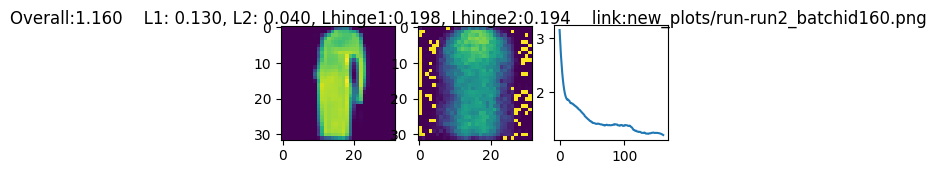

 10%|▉         | 180/1875 [09:02<1:24:31,  2.99s/it]

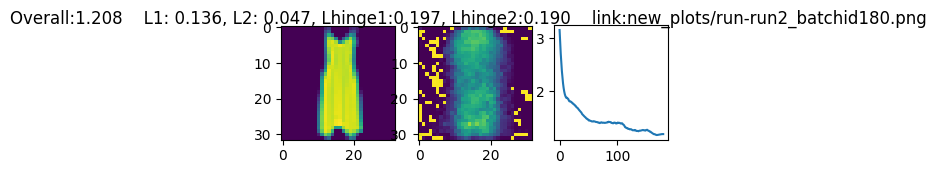

 11%|█         | 200/1875 [10:02<1:24:08,  3.01s/it]

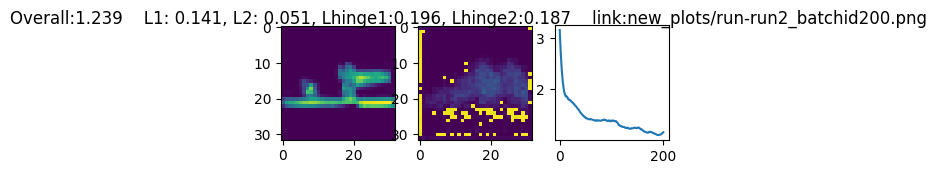

 12%|█▏        | 220/1875 [11:02<1:21:31,  2.96s/it]

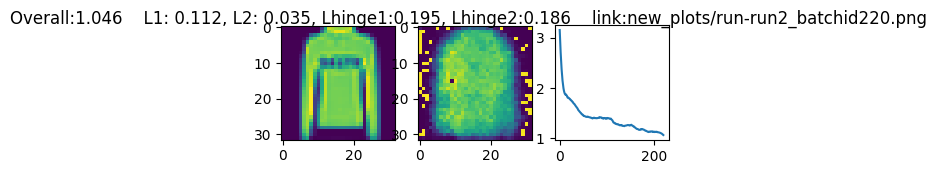

 13%|█▎        | 240/1875 [12:02<1:21:05,  2.98s/it]

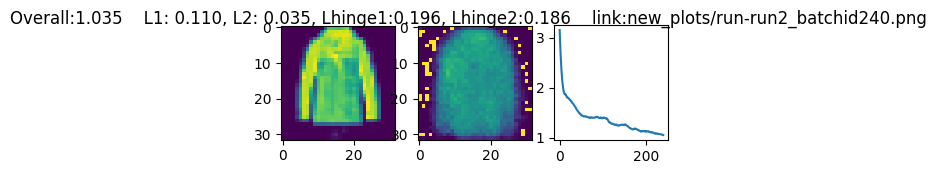

 14%|█▍        | 260/1875 [13:02<1:19:41,  2.96s/it]

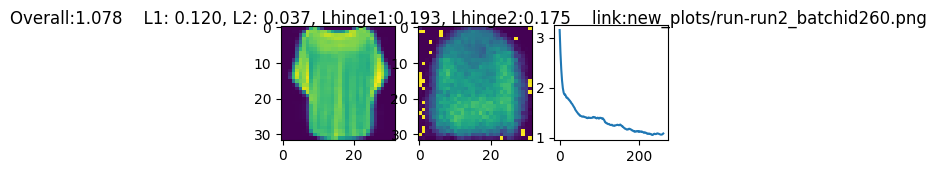

 15%|█▍        | 280/1875 [14:02<1:18:40,  2.96s/it]

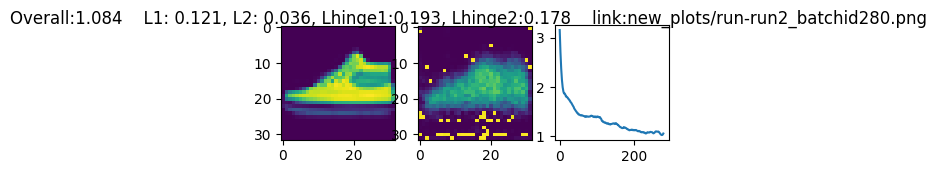

 16%|█▌        | 300/1875 [15:04<1:18:13,  2.98s/it]

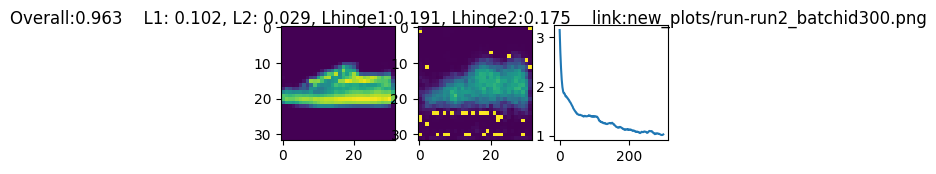

 17%|█▋        | 320/1875 [16:04<1:17:24,  2.99s/it]

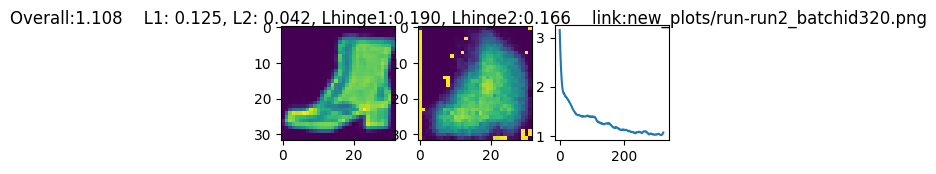

 18%|█▊        | 340/1875 [17:05<1:15:31,  2.95s/it]

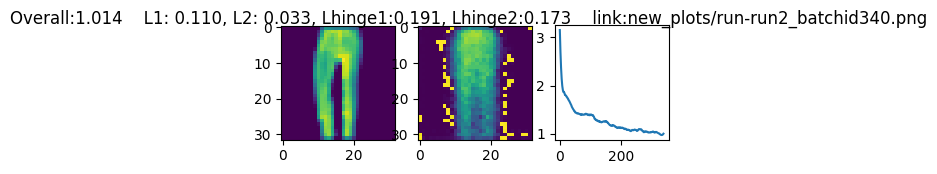

 19%|█▉        | 360/1875 [18:04<1:15:09,  2.98s/it]

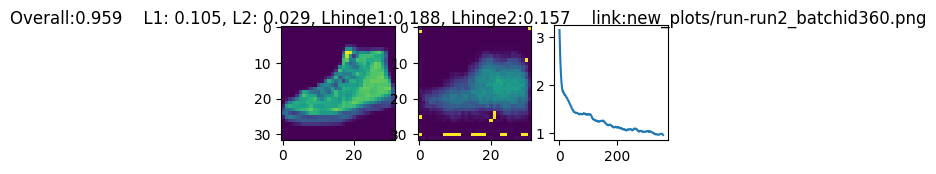

 20%|██        | 380/1875 [19:06<1:15:09,  3.02s/it]

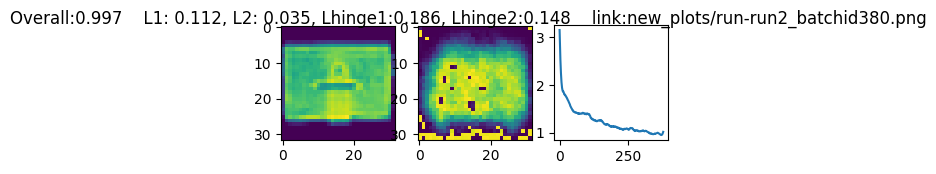

 21%|██▏       | 400/1875 [20:07<1:14:58,  3.05s/it]

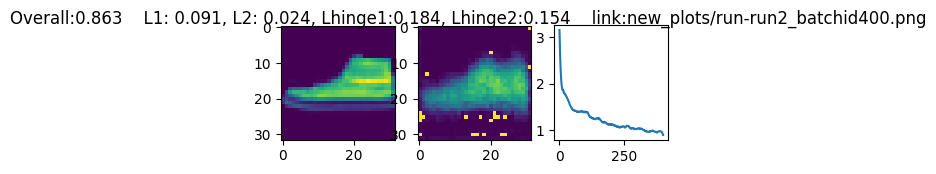

 22%|██▏       | 420/1875 [21:08<1:17:14,  3.19s/it]

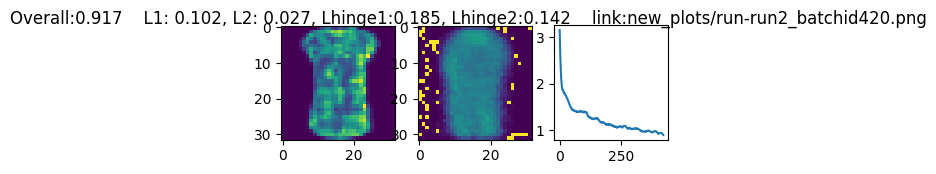

 23%|██▎       | 440/1875 [22:08<1:13:48,  3.09s/it]

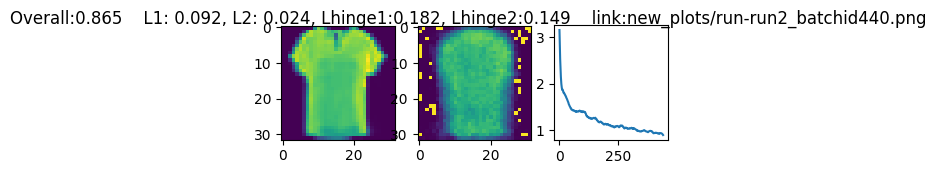

 25%|██▍       | 460/1875 [23:08<1:09:58,  2.97s/it]

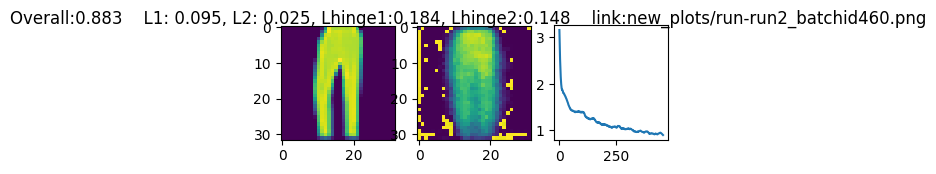

 26%|██▌       | 480/1875 [24:09<1:09:44,  3.00s/it]

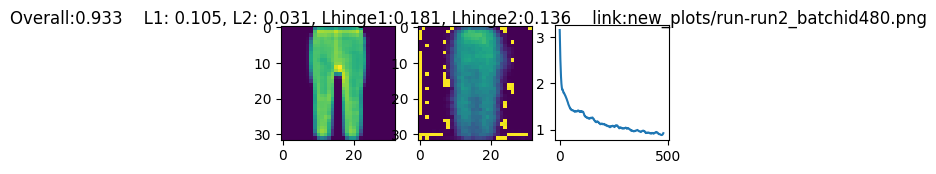

 27%|██▋       | 500/1875 [25:10<1:09:27,  3.03s/it]

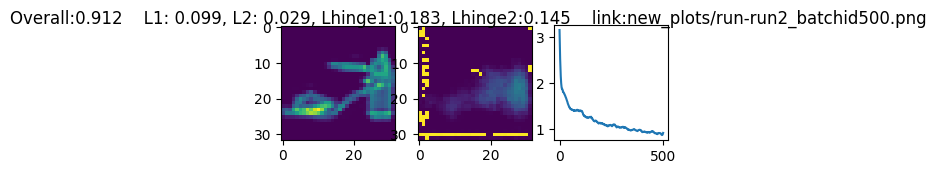

 28%|██▊       | 520/1875 [26:11<1:08:27,  3.03s/it]

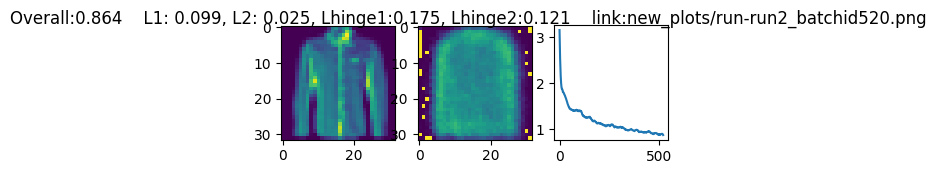

 29%|██▉       | 540/1875 [27:12<1:07:22,  3.03s/it]

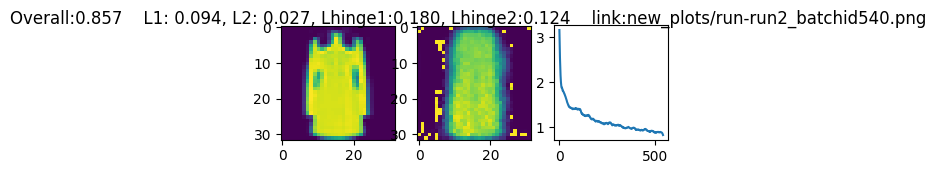

 30%|██▉       | 560/1875 [28:13<1:05:27,  2.99s/it]

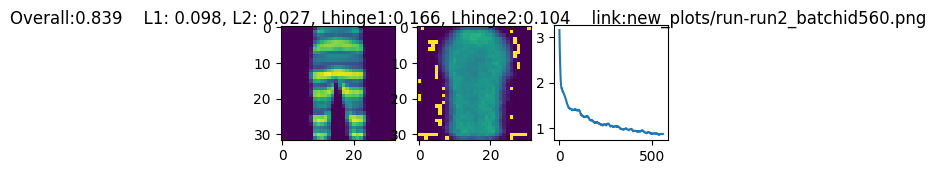

 31%|███       | 580/1875 [29:14<1:04:54,  3.01s/it]

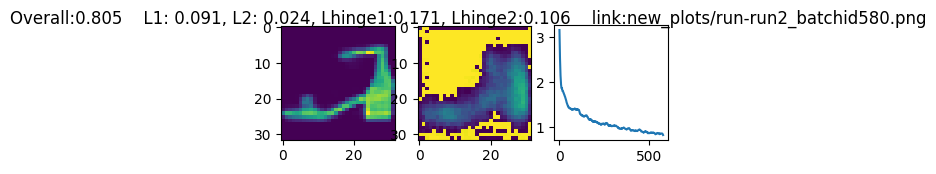

 32%|███▏      | 600/1875 [30:15<1:04:12,  3.02s/it]

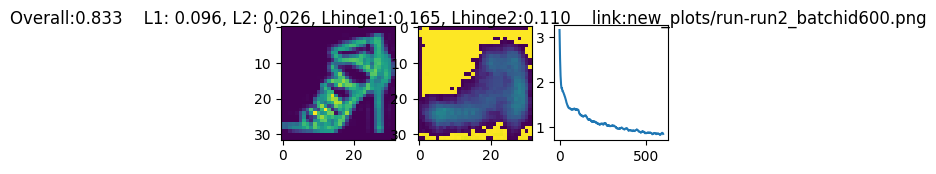

 33%|███▎      | 620/1875 [31:15<1:02:55,  3.01s/it]

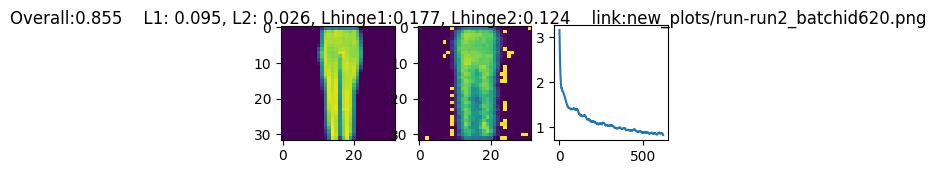

 34%|███▍      | 640/1875 [32:16<1:01:30,  2.99s/it]

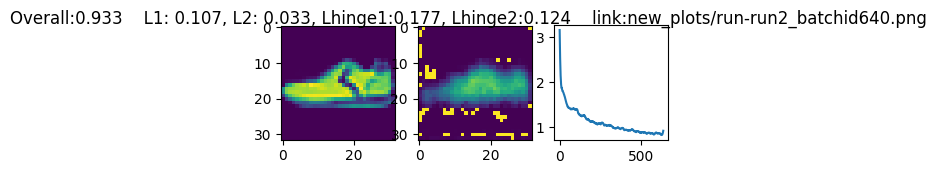

 35%|███▌      | 660/1875 [33:18<1:01:33,  3.04s/it]

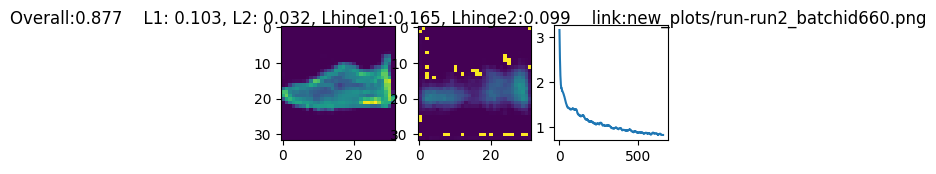

 36%|███▋      | 680/1875 [34:19<1:00:12,  3.02s/it]

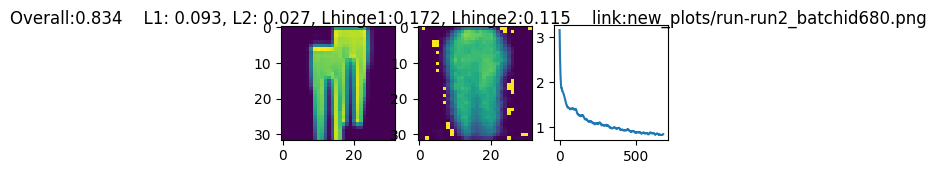

 37%|███▋      | 700/1875 [35:20<59:00,  3.01s/it]  

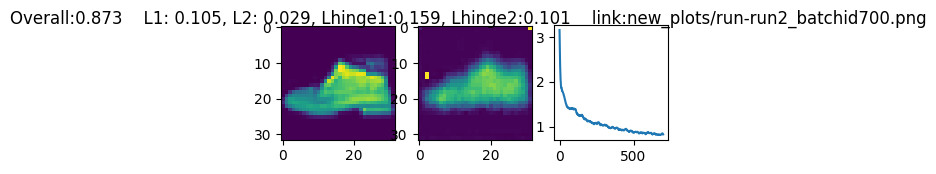

 38%|███▊      | 720/1875 [36:20<57:43,  3.00s/it]  

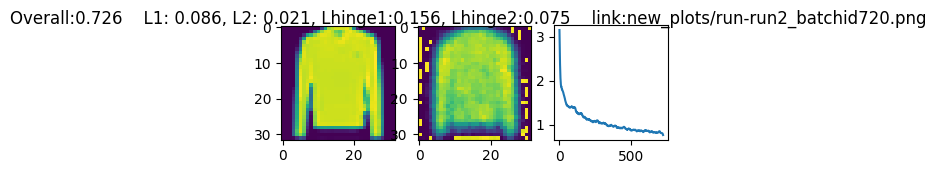

 39%|███▉      | 740/1875 [37:21<57:07,  3.02s/it]  

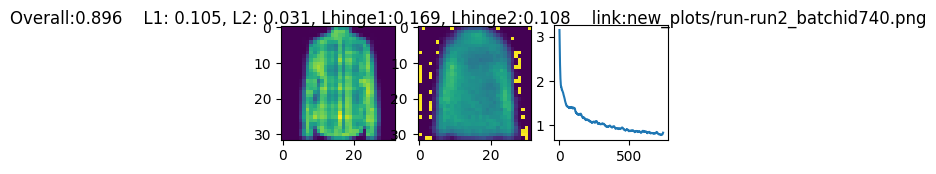

 41%|████      | 760/1875 [38:21<55:04,  2.96s/it]

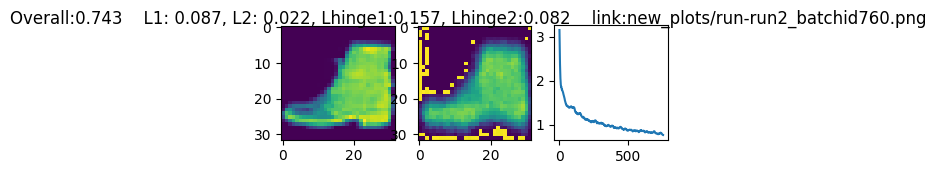

 42%|████▏     | 780/1875 [39:22<54:13,  2.97s/it]

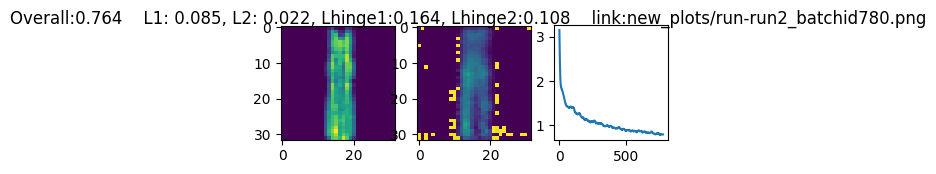

 43%|████▎     | 800/1875 [40:23<54:01,  3.02s/it]

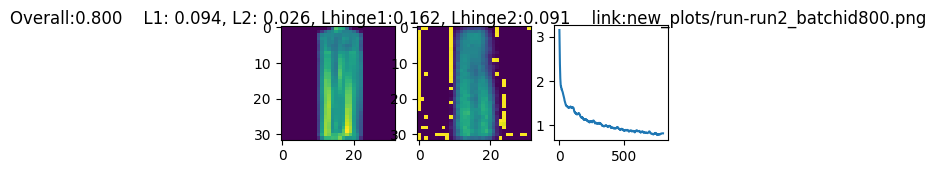

 44%|████▎     | 820/1875 [41:24<52:58,  3.01s/it]

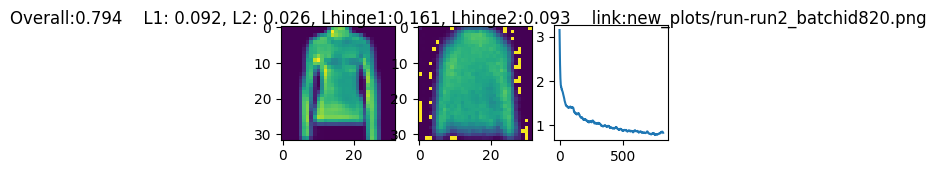

 45%|████▍     | 840/1875 [42:24<51:56,  3.01s/it]

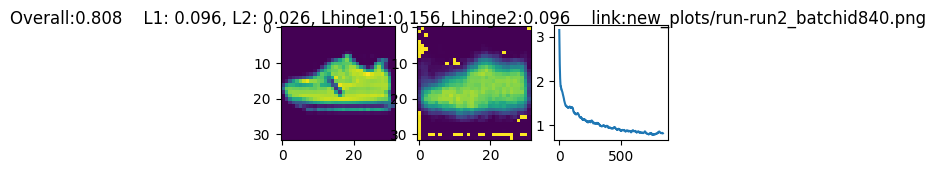

 46%|████▌     | 860/1875 [43:26<50:53,  3.01s/it]

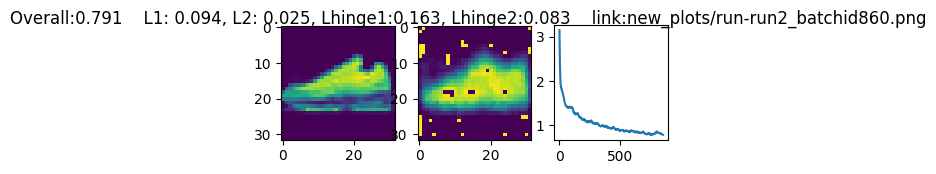

 47%|████▋     | 880/1875 [44:26<49:36,  2.99s/it]

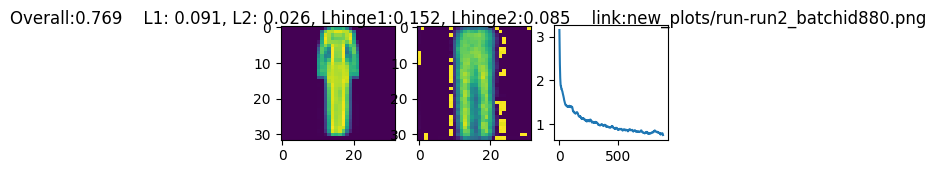

 48%|████▊     | 900/1875 [45:28<48:54,  3.01s/it]

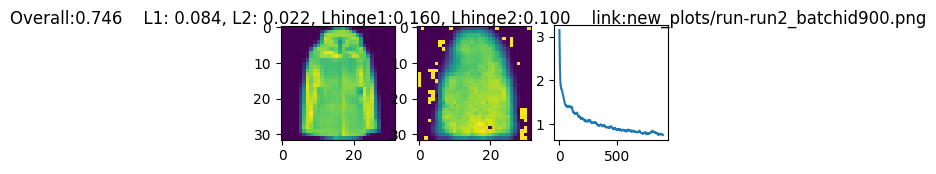

 49%|████▉     | 920/1875 [46:28<48:13,  3.03s/it]

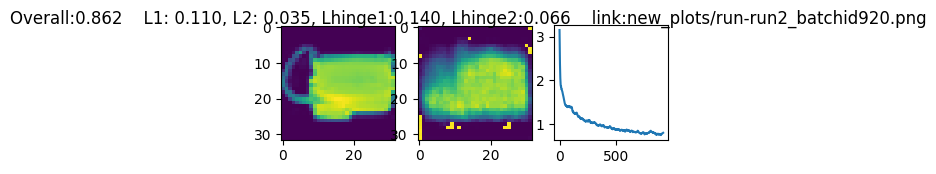

 50%|█████     | 940/1875 [47:30<46:56,  3.01s/it]

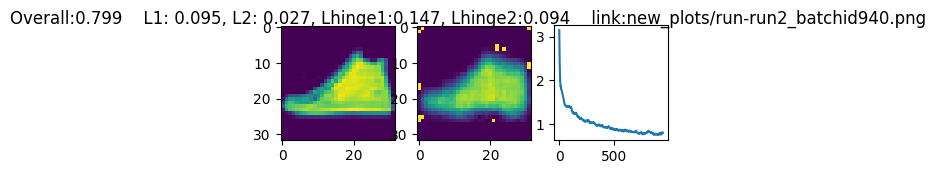

 51%|█████     | 960/1875 [48:30<46:24,  3.04s/it]

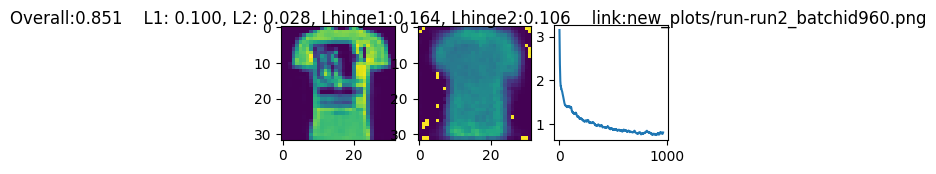

 52%|█████▏    | 980/1875 [49:31<44:09,  2.96s/it]

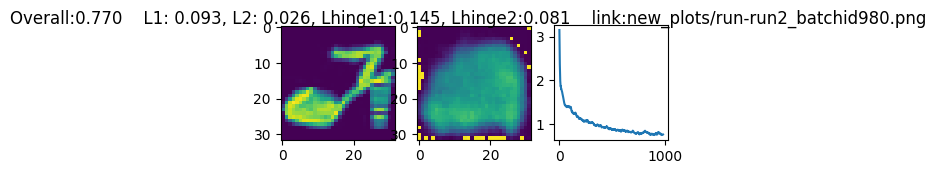

 53%|█████▎    | 1000/1875 [50:31<43:18,  2.97s/it]

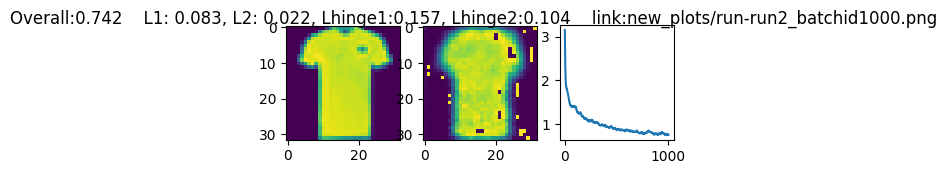

 54%|█████▍    | 1020/1875 [51:32<42:40,  2.99s/it]

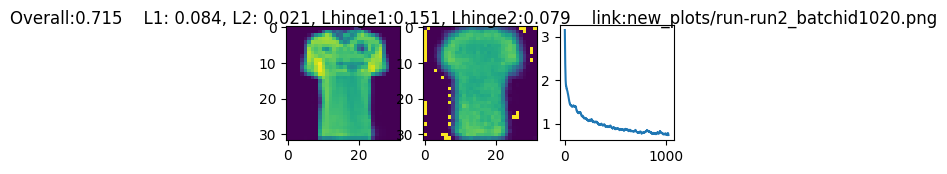

 55%|█████▌    | 1040/1875 [52:34<42:11,  3.03s/it]

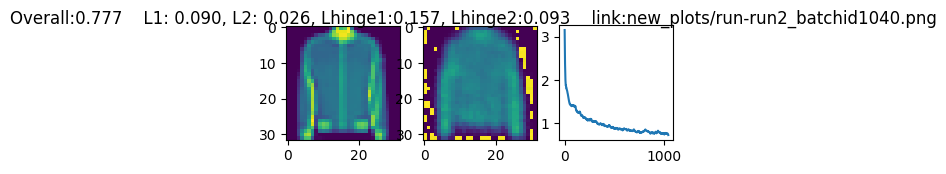

 57%|█████▋    | 1060/1875 [53:35<41:21,  3.04s/it]

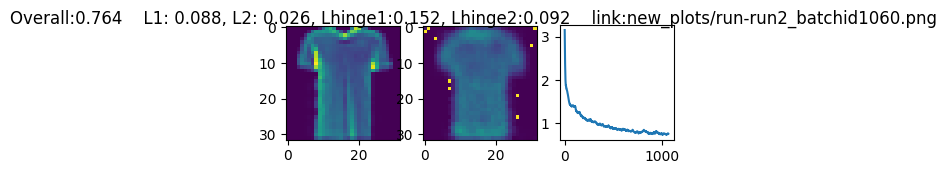

 58%|█████▊    | 1080/1875 [54:36<39:29,  2.98s/it]

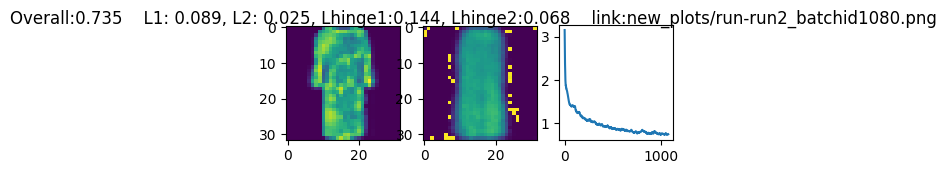

 59%|█████▊    | 1100/1875 [55:37<38:38,  2.99s/it]

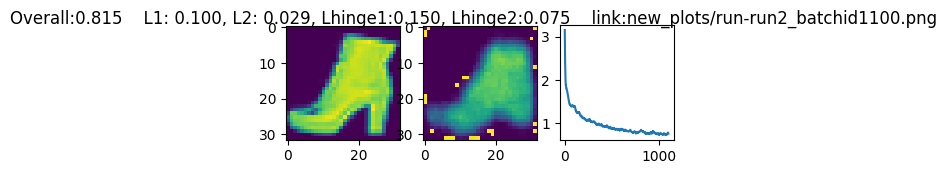

 60%|█████▉    | 1120/1875 [56:39<38:35,  3.07s/it]

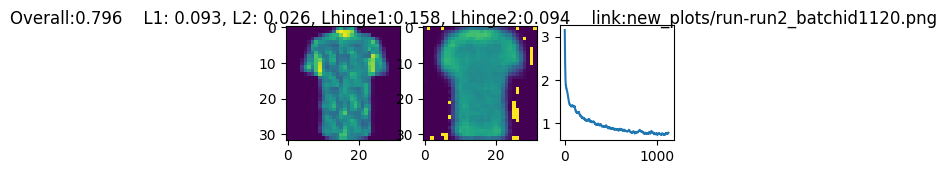

 61%|██████    | 1140/1875 [57:40<36:51,  3.01s/it]

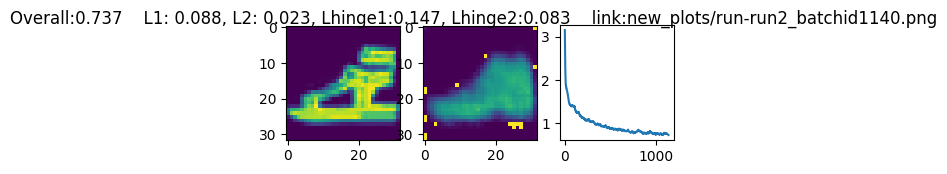

 62%|██████▏   | 1160/1875 [58:41<36:02,  3.02s/it]

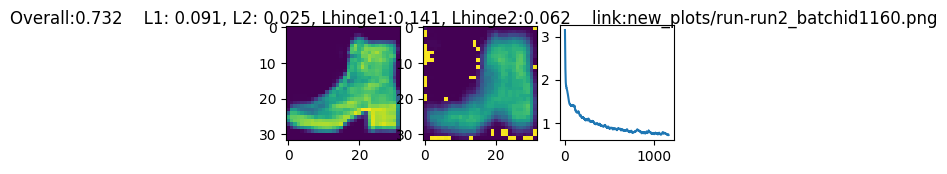

 63%|██████▎   | 1180/1875 [59:42<35:04,  3.03s/it]

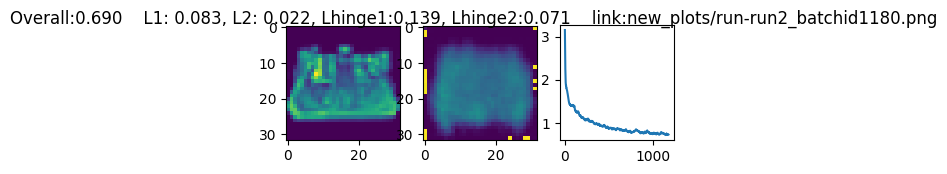

 64%|██████▍   | 1200/1875 [1:00:44<35:56,  3.20s/it]

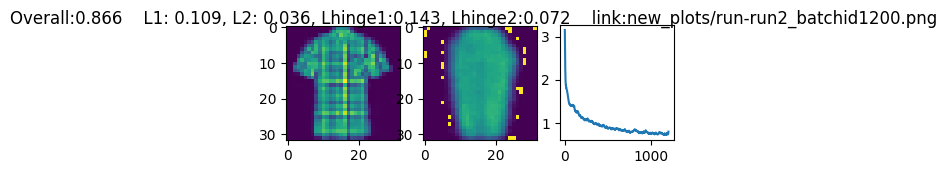

 65%|██████▌   | 1220/1875 [1:01:45<33:08,  3.04s/it]

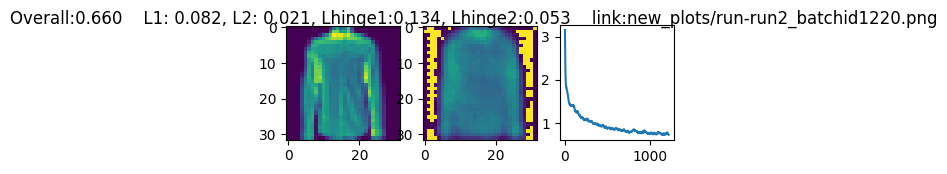

 66%|██████▌   | 1240/1875 [1:02:47<34:32,  3.26s/it]

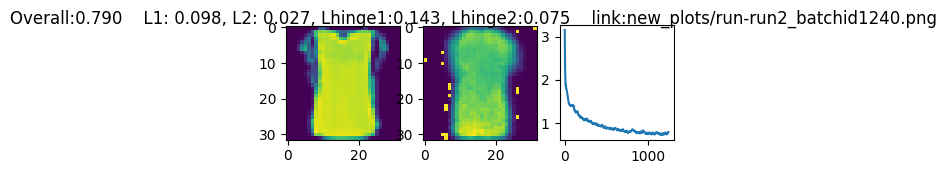

 67%|██████▋   | 1260/1875 [1:03:47<30:40,  2.99s/it]

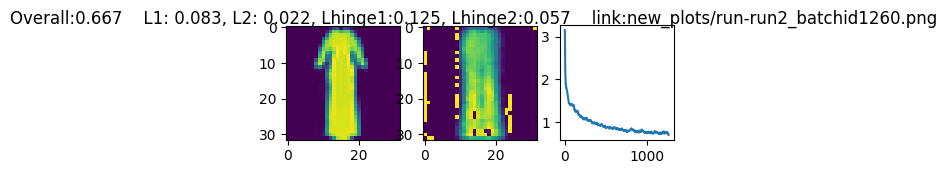

 68%|██████▊   | 1280/1875 [1:04:49<30:52,  3.11s/it]

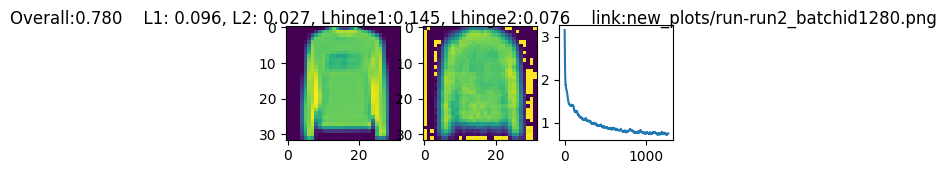

 69%|██████▉   | 1300/1875 [1:05:50<29:00,  3.03s/it]

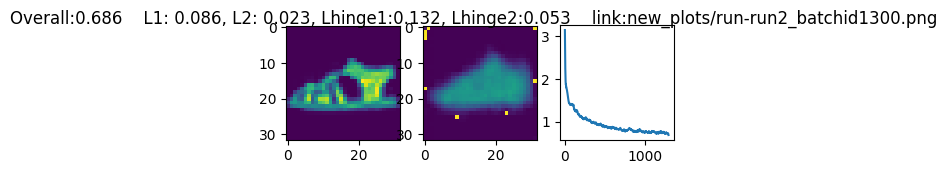

 70%|███████   | 1320/1875 [1:06:52<27:53,  3.02s/it]

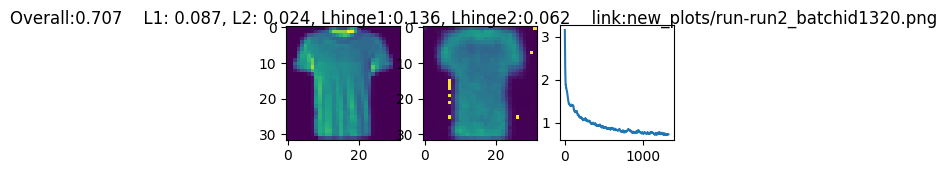

 71%|███████▏  | 1340/1875 [1:07:53<26:51,  3.01s/it]

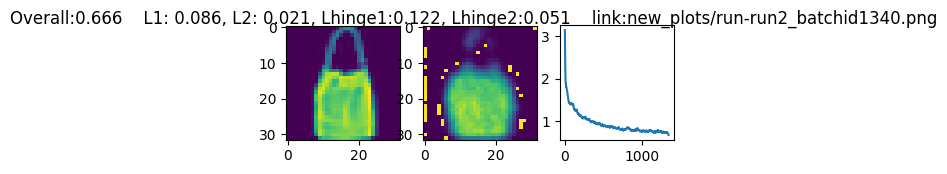

 73%|███████▎  | 1360/1875 [1:08:55<25:31,  2.97s/it]

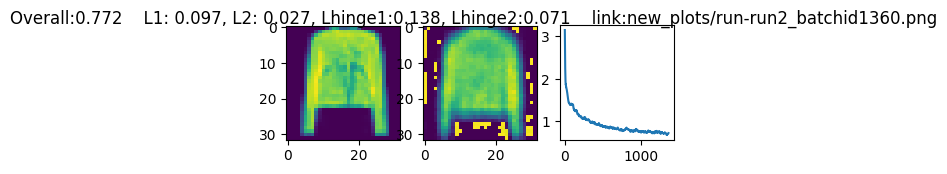

 74%|███████▎  | 1380/1875 [1:09:57<25:09,  3.05s/it]

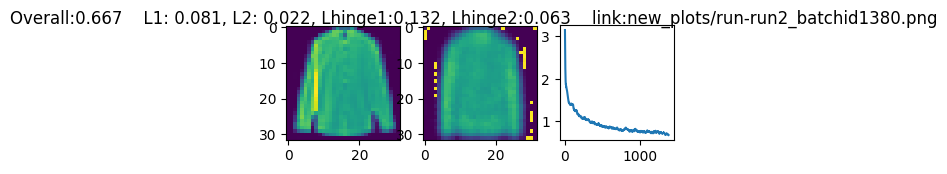

 75%|███████▍  | 1400/1875 [1:11:00<25:19,  3.20s/it]

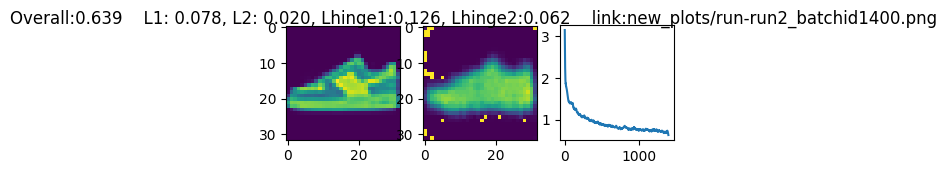

 76%|███████▌  | 1420/1875 [1:12:02<23:13,  3.06s/it]

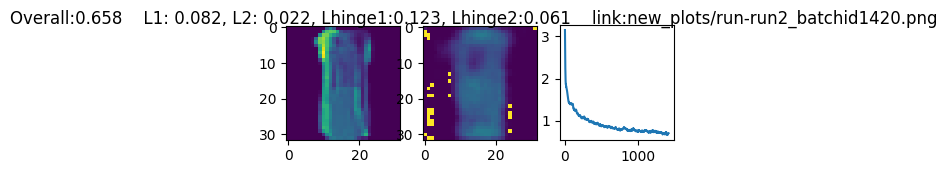

 77%|███████▋  | 1440/1875 [1:13:02<21:39,  2.99s/it]

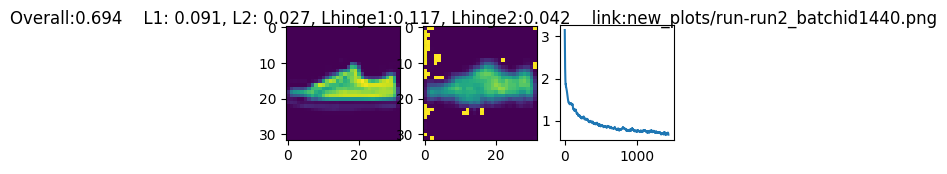

 78%|███████▊  | 1460/1875 [1:14:03<20:54,  3.02s/it]

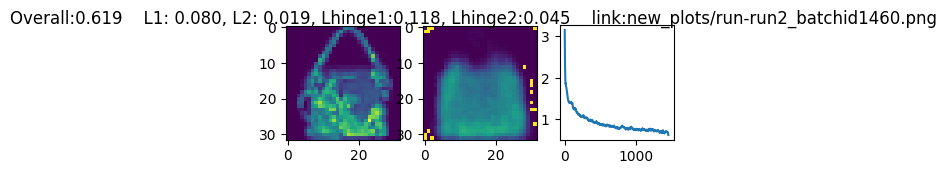

 79%|███████▉  | 1480/1875 [1:15:05<19:52,  3.02s/it]

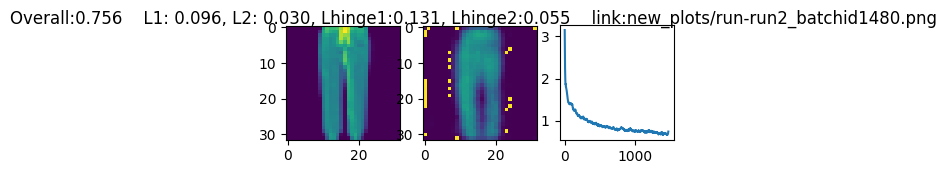

 80%|████████  | 1500/1875 [1:16:06<19:11,  3.07s/it]

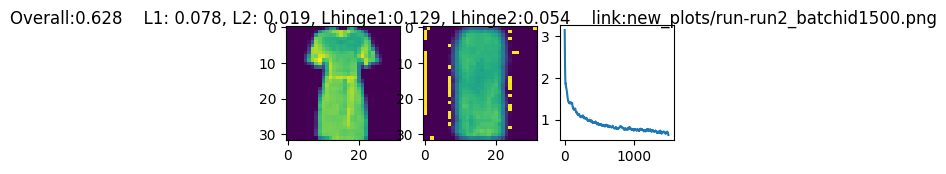

 81%|████████  | 1520/1875 [1:17:07<18:03,  3.05s/it]

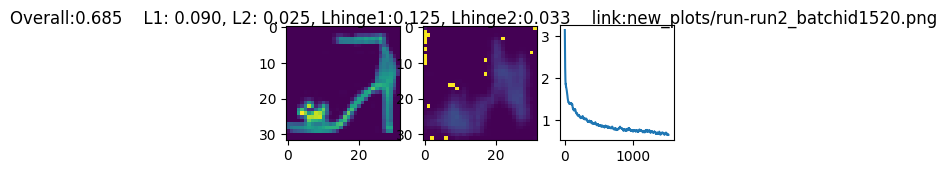

 82%|████████▏ | 1540/1875 [1:18:08<17:06,  3.06s/it]

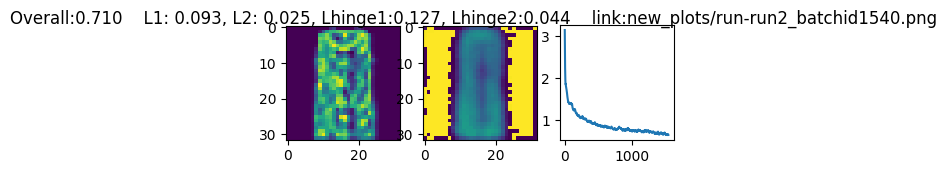

 83%|████████▎ | 1560/1875 [1:19:09<16:10,  3.08s/it]

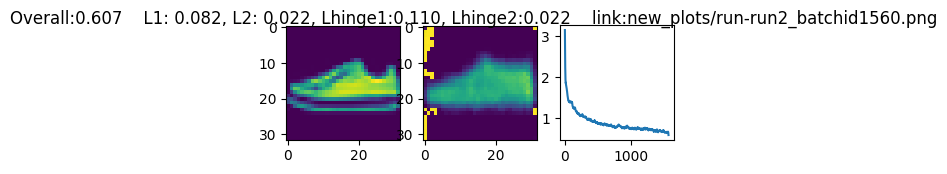

 84%|████████▍ | 1580/1875 [1:20:10<14:40,  2.98s/it]

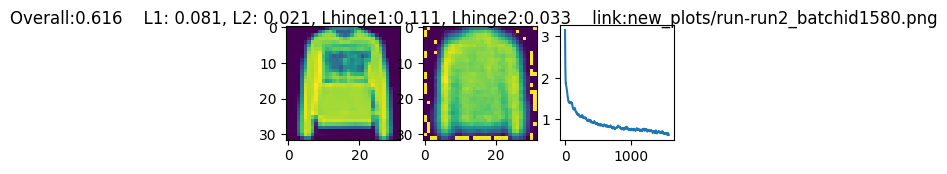

 85%|████████▌ | 1600/1875 [1:21:11<13:44,  3.00s/it]

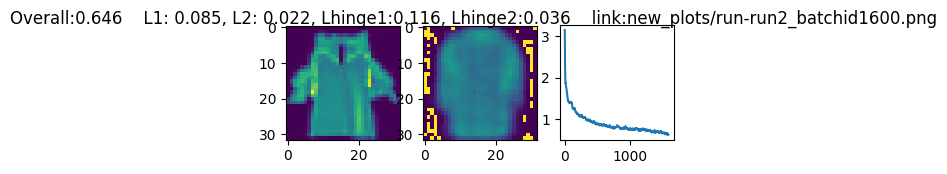

 86%|████████▋ | 1620/1875 [1:22:12<12:46,  3.01s/it]

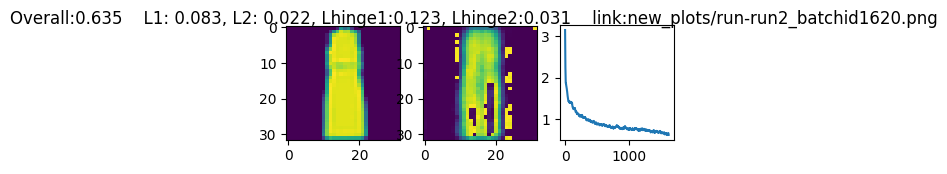

 87%|████████▋ | 1640/1875 [1:23:14<12:01,  3.07s/it]

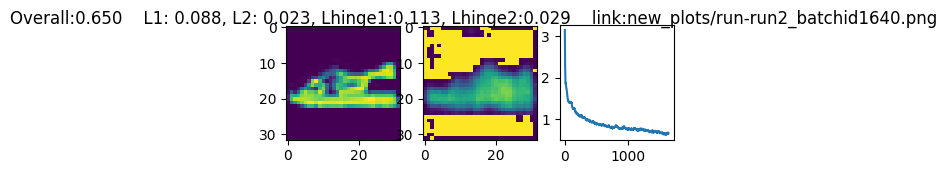

 89%|████████▊ | 1660/1875 [1:24:15<10:55,  3.05s/it]

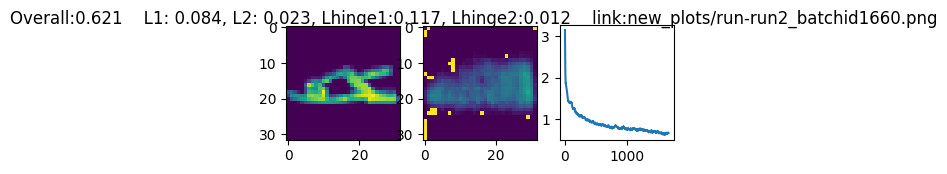

 90%|████████▉ | 1680/1875 [1:25:16<09:48,  3.02s/it]

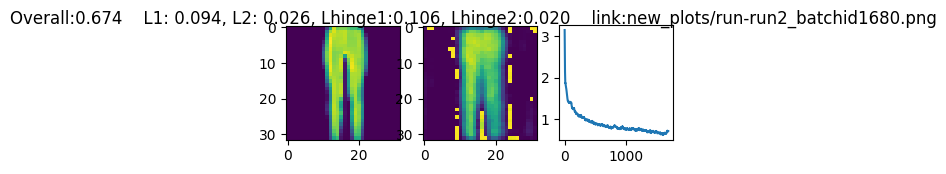

 91%|█████████ | 1700/1875 [1:26:17<09:01,  3.10s/it]

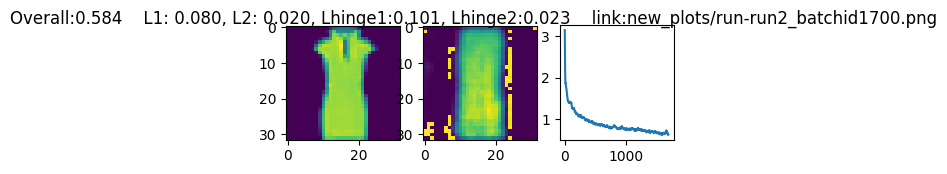

 92%|█████████▏| 1720/1875 [1:27:17<07:46,  3.01s/it]

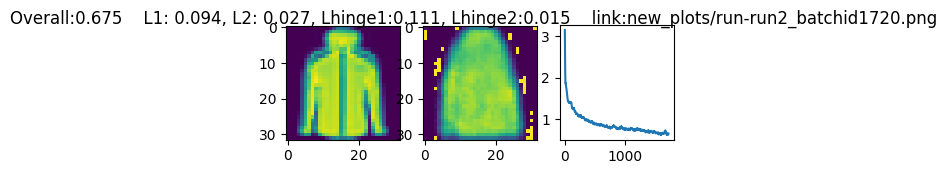

 93%|█████████▎| 1740/1875 [1:28:18<06:51,  3.05s/it]

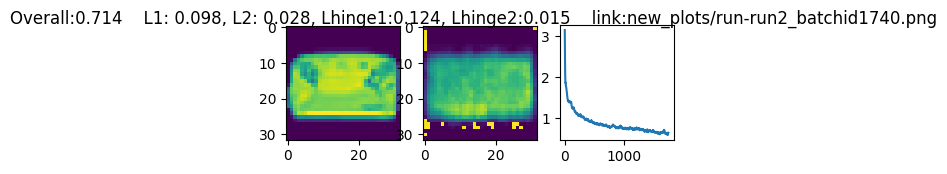

 94%|█████████▍| 1760/1875 [1:29:21<06:03,  3.16s/it]

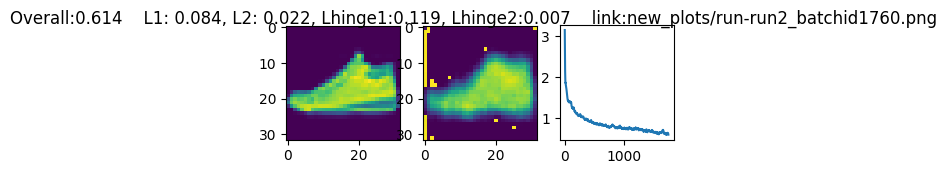

 95%|█████████▍| 1780/1875 [1:30:23<04:51,  3.07s/it]

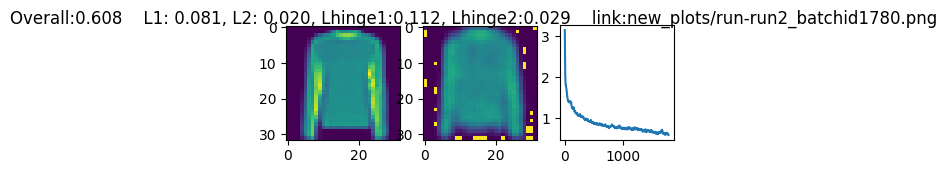

 96%|█████████▌| 1800/1875 [1:31:25<03:55,  3.14s/it]

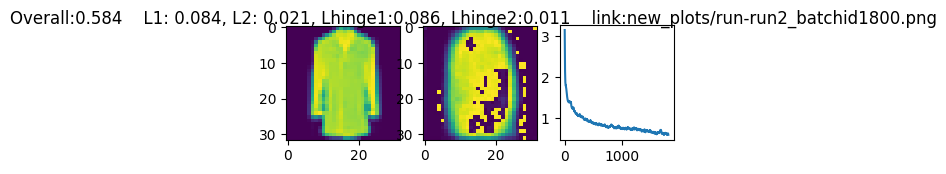

 97%|█████████▋| 1820/1875 [1:32:26<02:53,  3.16s/it]

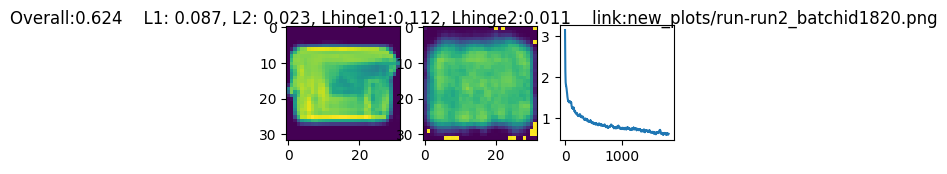

 98%|█████████▊| 1840/1875 [1:33:28<01:46,  3.04s/it]

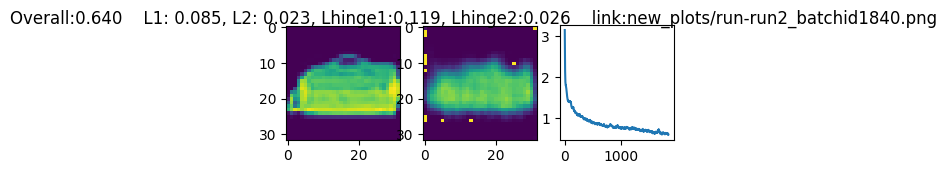

 99%|█████████▉| 1860/1875 [1:34:29<00:44,  2.98s/it]

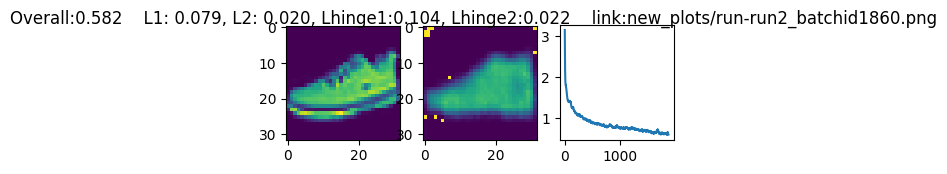

100%|██████████| 1875/1875 [1:35:15<00:00,  3.05s/it]


In [59]:
import random
import os
torch.autograd.set_detect_anomaly(True)
DRR = DRR.to(device)
victim = victim.to(device)
victim.eval()
from scipy.signal import savgol_filter

run_id += 1
run = f'run{run_id}'


for batch_id, (images, labels) in enumerate(tqdm(train_loader)):
  images, labels = images.to(device), labels.to(device)
  optimizer.zero_grad()

  xi = images
  fl = softmax(victim.features(xi) / T)
  fs = softmax(DRR.encoder(xi) / T)

  num_L1_samples = batch_size
  list_fl, list_fs = [], []

  xi_hats = DRR.decode(fl, fs)
  # print(xi_hats.shape, xi.shape)
  L1 = nn.L1Loss()(xi_hats, xi)
  L2 = nn.MSELoss()(xi_hats, xi)


  
  list_i = []
  list_ks = []
  # compute i and ks for each image
  for j in range(fl.shape[0]):
    list_i.append(fl[j].argmax(dim=0).item())
    k_range = [item for item in list(range(fl[j].shape[0])) if item != list_i[-1]]
    ks = random.sample(k_range, E)
    list_ks.append(ks)

  # compute the flks for every i
  list_flk = []
  list_fsk = []
  for j, i in enumerate(list_i):
    list_flk.append([])
    list_fsk.append([])
    for k in list_ks[j]:
      # make a copy and permute the positions
      flk = torch.clone(fl[j])
      fsk = torch.clone(fs[j])
      flk[i], flk[k] = flk[k], flk[i]
      list_flk[-1].append(flk)
      list_fsk[-1].append(fsk)
    list_flk[-1] = torch.stack(list_flk[-1], dim=0)
    list_fsk[-1] = torch.stack(list_fsk[-1], dim=0)

  
  flks = torch.cat(list_flk, dim=0)
  fsks = torch.cat(list_fsk, dim=0)
  list_fl.append(flks)
  list_fs.append(fsks)
  fl_batch = torch.cat(list_fl, dim=0)
  fs_batch = torch.cat(list_fs, dim=0)
    



  B = batch_size
  # the batch index is of size B + B*E -> 16 + 16*8 = 144, correct.
  # L1 is applied on B
  # 
  x = DRR.decode(fl_batch, fs_batch)

  
  xik_hats = [x[i:i+E] for i in range(0, 0 + B*E, E)]
  Lhinge2 = []
  Lhinge1 = []
  for j, (i, ks, xi_hat, xik_hat) in enumerate(list(zip(list_i, list_ks, xi_hats, xik_hats))):
    left = torch.unsqueeze(xi_hat, dim=0).expand(E, *xi_hat.shape)
    right = xik_hat
    Lhinge2j = d - torch.mean(nn.L1Loss(reduction='none')(left, right))
    Lhinge2j = nn.ReLU()(Lhinge2j)
    Lhinge2.append(Lhinge2j)
  

    left = []
    right = []
    for k1, xik1_hat in zip(ks, xik_hat):
      for k2, xik2_hat in zip(ks, xik_hat):
        if k1 != k2 and k1 < k2:
          left.append(xik1_hat)
          right.append(xik2_hat)
    left = torch.stack(left)
    right = torch.stack(right)
    Lhinge1j = d - torch.mean(nn.L1Loss(reduction='none')(left, right))
    Lhinge1j = nn.ReLU()(Lhinge1j)
    Lhinge1.append(Lhinge1j)
  Lhinge2 = torch.mean(torch.stack(Lhinge2))
  Lhinge1 = torch.mean(torch.stack(Lhinge1))
  loss = 5*L1 + 3*L2 + Lhinge1 + Lhinge2
  losses.append(loss.item())
  losses_drr[0].append(loss.item())
  losses_drr[1].append(L1.item())
  losses_drr[2].append(L2.item())
  losses_drr[3].append(Lhinge1.item())
  losses_drr[4].append(Lhinge2.item())
  # loss =  Lhinge1 + Lhinge2
  # print(f'Overall:{loss.item():.3f}    L1: {L1.item():.3f}, L2: {L2.item():.3f}, Lhinge1:{Lhinge1.item():.3f}, Lhinge2:{Lhinge2.item():.3f}')
  loss.backward()
  optimizer.step()

  if batch_id % 20 == 0:
    xi = xi[0]
    xi_hat = xi_hats[0]
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[5, 1.5])
    axs[0].imshow(transforms.ToPILImage()(xi    ))
    axs[1].imshow(transforms.ToPILImage()(xi_hat))
    if len(losses) > 25:
      axs[2].plot(savgol_filter(losses, 25, 3))
    img_link = f'new_plots/run-{run}_batchid{batch_id}.png'
    fig.suptitle(f'Overall:{loss.item():.3f}    L1: {L1.item():.3f}, L2: {L2.item():.3f}, Lhinge1:{Lhinge1.item():.3f}, Lhinge2:{Lhinge2.item():.3f}    link:{img_link}')
    plt.savefig(img_link)
    plt.show()
    # save model checkpoints
    count = 0
    success = False
    while success == False:
      if count == 10:
        print(f'ERROR ENCOUNTERED IN THE SAVE PORTION, exiting....')
        break
      try:
        os.mkdir(f'new_saved/checkpoints/ruz-{run}_batch_id-{batch_id}/')
        success = True
      except:
        run_id += 1
        run = f'run{run_id}'
        count += 1
    if success==False:
      break
    torch.save(DRR.state_dict(), f'new_saved/checkpoints/ruz-{run}_batch_id-{batch_id}/drr_fmnist.pt')
    torch.save(victim.state_dict(), f'new_saved/checkpoints/ruz-{run}_batch_id-{batch_id}/victim_fmnist.pt')







    



  



# testing the model

In [52]:
def bn_compute_drr(victim, drr, loader):
  bn_define(drr)
  drr.train()
  drr = drr.to(device)
  for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.to(device)
    images = xi
    generate_recons(xi, victim, drr)

def generate_recons(xi, v, drr):
    fl = softmax(v.features(xi) / T)
    fs = softmax(drr.encoder(xi) / T)
    xi_hat = drr.decode(fl, fs)
    return xi_hat

In [ ]:
victim = None
DRR = None
################ write which model to load after checking from the new_plots file

# DRR_model_path = ...
# victim_model_path = ...

# DRR = DecoderVGG(**drr_kwargs)
# DRR.load_state_dict(torch.load(DRR_model_path))
# victim = Victim(**victim_kwargs)
# victim.load_state_dict(torch.load(victim_model_path))
# DRR, victim = DRR.to(device), victim.to(device)

# for images, labels in train_loader: break
# images, labels = images.to(device), labels.to(device)
# xi = images
# generate_recons(images, victim, DRR).shape

In [ ]:
import foolbox as fb

In [ ]:
model = victim
fmodel = fb.PyTorchModel(model, bounds=(0, 1))

attack = fb.attacks.LinfPGD()
epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
for images, labels in test_loader:break
images, labels = images.to(device), labels.to(device)
_, advs, success = attack(fmodel, images, labels, epsilons=epsilons)

In [ ]:
print(f'reconstruction error for benign images:')
for i, epsilon in enumerate(epsilons):
    # fig, axs = plt.subplots(nrows=1, ncols=2)
    # print(xi.shape, advs[i].shape)
    xi_ = advs[i]
    xihat  = generate_recons(xi , victim, DRR)
    xihat_ = generate_recons(xi_, victim, DRR)
    error  = nn.MSELoss()(xihat , xi )
    error_ = nn.MSELoss()(xihat_, xi_)
    print(error.item(), error_.item())

        